In this notebook we will explore the Medicare Part D prescribing data that was released through the CMS data portal at https://data.cms.gov/resource/4uvc-gbfz. The goal is to demonstrate how this data can be used to find prescribers who prescribe in a similar way. For a psychiatrist in Washington, D.C. we will determine which prescribers prescribe most closely by computing a distance matrix based on the total claims. More information about the data can be found at [Prescriber_Methods.pdf](https://data.cms.gov/api/views/4uvc-gbfz/files/9hYW-2MBrXAbhKuRXBE0AMbG7pRA5Q0MQCsDIJzlkTI?download=true&filename=Prescriber_Methods.pdf).

In [1]:
import pandas as pd

In [2]:
md_base_url = "https://data.cms.gov/resource/4uvc-gbfz" # URL For The Data

The data set contains 23,650,520 rows. We are not going to pull the entire data set down but a subset of the data.  To determine which state to pull down we use the Socrata SODA API to do the computation server side.

In [3]:
count_url = md_base_url + "?" + "$select=count(*)"
print(count_url)
pd.read_json(count_url)

https://data.cms.gov/resource/4uvc-gbfz?$select=count(*)


,count
0,23645873


In [4]:
count_by_state_url = md_base_url + "?" + "$select=nppes_provider_state,count(nppes_provider_state)&$group=nppes_provider_state"
print(count_by_state_url)
by_state_df = pd.read_json(count_by_state_url)
by_state_df[by_state_df.count_nppes_provider_state < 50000]

https://data.cms.gov/resource/4uvc-gbfz?$select=nppes_provider_state,count(nppes_provider_state)&$group=nppes_provider_state


,count_nppes_provider_state,nppes_provider_state
0,49,AS
1,30,AA
2,25,XX
3,348,MP
4,240,AE
5,2738,VI
6,1816,GU
7,1072,ZZ
8,28329,AK
10,95,AP


Socrata SODA version 2.0 of the API has a limit of 50,000 rows. It is possible to implement a strategy using the `$limit` and `$offset` operators in their API to extract larger datasets. We will focus on extracting data for prescribers that list their location in the District of Columbia. Rather than using the `pd.read_json()` using the `requests` library will be demonstrated. This will let us see the header of the HTTP response of the request.

In [5]:
import requests

In [6]:
r = requests.get(md_base_url, params={'$where': "nppes_provider_state='WY'", "$limit": 50000})

In [7]:
r.headers

{'Server': 'nginx', 'Date': 'Mon, 01 Jul 2019 18:06:38 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'X-Socrata-RequestId': '2uxqv7t0sb59djiid1znix1gd', 'Access-Control-Allow-Origin': '*', 'ETag': '"54a4725e0cbcafccb5e253fc6a67f1b--gzip"', 'Last-Modified': 'Wed, 14 Nov 2018 19:13:19 UTC', 'X-SODA2-Warning': 'X-SODA2-Fields, X-SODA2-Types, and X-SODA2-Legacy-Types are deprecated', 'X-SODA2-Fields': '["drug_name","total_day_supply","npi","nppes_provider_first_name","total_claim_count_ge65","generic_name","total_30_day_fill_count_ge65","specialty_desc","total_day_supply_ge65","total_claim_count","ge65_redact_flag","nppes_provider_city","total_30_day_fill_count","bene_count_ge65","nppes_provider_state","nppes_provider_last_org_name","total_drug_cost","description_flag","bene_count_ge65_redact_flag","total_drug_cost_ge65","bene_count"]', 'X-SODA2-Types': '["text","number","text","text","number","text","number","text","nu

In [8]:
prescriber_df = pd.read_json(r.content)

In [9]:
# Uncomment if you are unable to install the requests library
# prescriber_df = pd.read_json(prescriber_url)

In [10]:
prescriber_df.head(10)

,bene_count,bene_count_ge65,bene_count_ge65_redact_flag,description_flag,drug_name,ge65_redact_flag,generic_name,npi,nppes_provider_city,nppes_provider_first_name,...,nppes_provider_state,specialty_desc,total_30_day_fill_count,total_30_day_fill_count_ge65,total_claim_count,total_claim_count_ge65,total_day_supply,total_day_supply_ge65,total_drug_cost,total_drug_cost_ge65
0,NaN,NaN,*,S,ESTRADIOL,*,ESTRADIOL,1003021064,CHEYENNE,JANET,...,WY,Obstetrics/Gynecology,15.0,NaN,11,NaN,450,NaN,72.58,NaN
1,NaN,NaN,#,S,ABILIFY,#,ARIPIPRAZOLE,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,39.0,NaN,31,NaN,759,NaN,16916.38,NaN
2,NaN,NaN,*,S,ACETAMINOPHEN-CODEINE,NaN,ACETAMINOPHEN WITH CODEINE,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,44.0,44.0,44,44.0,773,773.0,731.59,731.59
3,18.0,NaN,#,S,ADVAIR DISKUS,#,FLUTICASONE/SALMETEROL,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,84.0,NaN,70,NaN,2520,NaN,21571.17,NaN
4,15.0,NaN,#,S,ALENDRONATE SODIUM,NaN,ALENDRONATE SODIUM,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,111.5,92.9,80,65.0,3186,2654.0,925.51,766.89
5,78.0,NaN,#,S,ALLOPURINOL,NaN,ALLOPURINOL,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,551.0,491.0,374,334.0,16451,14651.0,2472.25,2276.14
6,31.0,15.0,NaN,S,ALPRAZOLAM,NaN,ALPRAZOLAM,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,121.0,44.0,116,40.0,3517,1267.0,912.23,262.66
7,NaN,NaN,#,S,AMIODARONE HCL,#,AMIODARONE HCL,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,33.0,NaN,31,NaN,990,NaN,379.06,NaN
8,15.0,NaN,*,S,AMITRIPTYLINE HCL,NaN,AMITRIPTYLINE HCL,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,111.0,85.0,79,55.0,3286,2521.0,585.62,478.70
9,51.0,NaN,#,S,AMLODIPINE BESYLATE,NaN,AMLODIPINE BESYLATE,1003059684,ROCK SPRINGS,LEAH,...,WY,Internal Medicine,399.0,357.0,252,216.0,11912,10652.0,2154.89,1937.00


In [11]:
prescriber_df = prescriber_df.sort_values(by=["specialty_desc","npi","drug_name"])

A prescriber is identified by the NPI (National Provider Identifier). The NPI is a 10-digit number. We will use the Bloom API as an example of what information is linked to the NPI for a prescriber. This NPI associated data is self-reported by the provider. When a provider writes a prescription and the prescription is filled by a patient the NPI and the drug prescribed is recorded in the Medicare claims database. This data was aggregated over calendar year 2013 to form the underlying database.  This allows us to connect what drugs the prescriber prescribed to Medicare members. A prescriber may prescribe to other patients not in Medicare. This data is not in this data set. To protect the privacy of individuals only drugs with more than 11 claims during the year are included in this data set.

In [12]:
len("1487818670")

10

In [13]:
#r = requests.get("http://www.bloomapi.com/api/search", 
#                 params={"limit": 10,"offset": 0, "key1": "npi", "op1": "eq", "value1": 1487818670})
#r.json()

In [14]:
# prescriber_df.to_csv("./data/medicare_dc_prescriber_raw_2013.csv")
# Uncomment last line if there are API Connection Problems
# prescriber_df = pd.read_csv("./data/medicare_dc_prescriber_raw_2013.csv")

In [15]:
import numpy as np

In [16]:
npi_drug_cross_df = pd.crosstab(prescriber_df["npi"], prescriber_df["drug_name"], values=prescriber_df["total_claim_count"], 
                                  aggfunc=np.sum)

If you have worked with Microsoft Excel you might be familiar with the concept of a pivot table. We want to create a dataframe where each row is a prescriber identified by their NPI and the columns of the table are the names of the drugs.

In [17]:
npi_drug_cross_df.head(5)

drug_name,ABILIFY,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACIPHEX,ACTONEL,ACTOPLUS MET XR,ACTOS,ACYCLOVIR,...,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONISAMIDE,ZOSTAVAX,ZOVIA 1-35E,ZYFLO CR,ZYLET,ZYMAXID,ZYPREXA,ZYTIGA
npi,,,,,,,,,,,,,,,,,,,,,
1003021064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003059684,31.0,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,...,101.0,38.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
1003066838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003068263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003071804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To replace the NaN (not a number) from the cells with zero the `fillna()` method is used.

In [18]:
npi_drug_cross_df = npi_drug_cross_df.fillna(0)

Now it is simple to find the total number of claims for the drug Abilify.

In [19]:
npi_drug_cross_df["ACETAMINOPHEN-CODEINE"].sum()

1790.0

To count the number of drugs we will add a new field called `drug_count` to the dataframe. Then we will use the `groupby()` and `agg()` methods to create a new dataframe. 

In [20]:
prescriber_df["drug_count"] = 1

In [21]:
prescriber_specialty_df = prescriber_df.groupby(["npi","specialty_desc"]).agg({"total_claim_count": np.sum,  "drug_count": np.sum})

To merge the tables we need to flatten the indices.

In [22]:
prescriber_specialty_df.reset_index(level=["npi","specialty_desc"], inplace=True)

In [23]:
prescriber_specialty_df.head(10)

,npi,specialty_desc,total_claim_count,drug_count
0,1003021064,Obstetrics/Gynecology,11,1
1,1003059684,Internal Medicine,12836,196
2,1003066838,Internal Medicine,390,20
3,1003068263,Family Practice,1791,63
4,1003071804,Family Practice,472,23
5,1003079302,Physician Assistant,65,4
6,1003096959,Physician Assistant,129,7
7,1003167594,Physician Assistant,103,5
8,1003801051,Family Practice,12,1
9,1003837881,Optometry,28,1


In [24]:
prescriber_specialty_drugs_df = pd.merge(prescriber_specialty_df, npi_drug_cross_df.reset_index(level=["npi"]), on="npi")

In [25]:
prescriber_specialty_drugs_df.head(5)

,npi,specialty_desc,total_claim_count,drug_count,ABILIFY,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACIPHEX,...,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONISAMIDE,ZOSTAVAX,ZOVIA 1-35E,ZYFLO CR,ZYLET,ZYMAXID,ZYPREXA,ZYTIGA
0,1003021064,Obstetrics/Gynecology,11,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003059684,Internal Medicine,12836,196,31.0,0.0,0.0,44.0,0.0,0.0,...,101.0,38.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003066838,Internal Medicine,390,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003068263,Family Practice,1791,63,0.0,0.0,0.0,0.0,0.0,0.0,...,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003071804,Family Practice,472,23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we will show that different medical specialties prescribe different numbers of drugs. We expect that internal medicine which see a large number of different patients will prescribe the most number of drugs compared to a specialized field such as psychiatry.

In [26]:
import seaborn as sb

In [27]:
%matplotlib inline

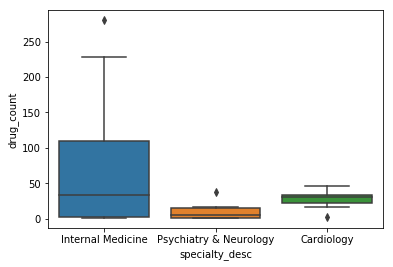

In [28]:
sb.boxplot(x="specialty_desc", y="drug_count", 
           data=prescriber_specialty_drugs_df[(prescriber_specialty_drugs_df["specialty_desc"] == "Cardiology") |
           (prescriber_specialty_drugs_df["specialty_desc"] == "Internal Medicine") |
           (prescriber_specialty_drugs_df["specialty_desc"] == "Psychiatry & Neurology")]
          )

Next we will build the dataframes and corresponding matrices to compute the euclidean distance between two Medicare prescribers in DC. Rather than creating a crosstab by `"drug_name"` we will use the `"generic_name"`. The branded drug Abilify has the generic name of ARIPiprazole. A great tool for understanding the relationship between active ingredients, generic name and branded product is [RxNav](https://rxnav.nlm.nih.gov/).

In [29]:
npi_generic_cross_df = pd.crosstab(prescriber_df["npi"], prescriber_df["generic_name"], values=prescriber_df["total_claim_count"], 
                                  aggfunc=np.sum)

In [30]:
npi_generic_cross_df = npi_generic_cross_df.fillna(0)

In [31]:
npi_generic_cross_df.head(5)

generic_name,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE/LAMIVUDINE,ABATACEPT,ABIRATERONE ACETATE,ACAMPROSATE CALCIUM,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN WITH CODEINE,ACETAZOLAMIDE,ACITRETIN,...,VERAPAMIL HCL,VILAZODONE HYDROCHLORIDE,WARFARIN SODIUM,ZAFIRLUKAST,ZALEPLON,ZILEUTON,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
npi,,,,,,,,,,,,,,,,,,,,,
1003021064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003059684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,...,22.0,0.0,222.0,0.0,0.0,0.0,0.0,139.0,0.0,11.0
1003066838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003068263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0
1003071804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
npi_generic_cross_df.columns

Index(['0.9 % SODIUM CHLORIDE', 'ABACAVIR SULFATE/LAMIVUDINE', 'ABATACEPT',
       'ABIRATERONE ACETATE', 'ACAMPROSATE CALCIUM', 'ACARBOSE',
       'ACEBUTOLOL HCL', 'ACETAMINOPHEN WITH CODEINE', 'ACETAZOLAMIDE',
       'ACITRETIN',
       ...
       'VERAPAMIL HCL', 'VILAZODONE HYDROCHLORIDE', 'WARFARIN SODIUM',
       'ZAFIRLUKAST', 'ZALEPLON', 'ZILEUTON', 'ZIPRASIDONE HCL',
       'ZOLPIDEM TARTRATE', 'ZONISAMIDE', 'ZOSTER VACCINE LIVE/PF'],
      dtype='object', name='generic_name', length=679)

In [33]:
prescriber_specialty_generic_df = pd.merge(prescriber_specialty_df, npi_generic_cross_df.reset_index(level=["npi"]), on="npi")

In [34]:
prescriber_specialty_generic_df.head(5)

,npi,specialty_desc,total_claim_count,drug_count,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE/LAMIVUDINE,ABATACEPT,ABIRATERONE ACETATE,ACAMPROSATE CALCIUM,ACARBOSE,...,VERAPAMIL HCL,VILAZODONE HYDROCHLORIDE,WARFARIN SODIUM,ZAFIRLUKAST,ZALEPLON,ZILEUTON,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
0,1003021064,Obstetrics/Gynecology,11,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003059684,Internal Medicine,12836,196,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,0.0,222.0,0.0,0.0,0.0,0.0,139.0,0.0,11.0
2,1003066838,Internal Medicine,390,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003068263,Family Practice,1791,63,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0
4,1003071804,Family Practice,472,23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
prescriber_specialty_generic_df = prescriber_specialty_generic_df.sort_values(by=["specialty_desc", "npi"])

We will shift from using the Pandas dataframe object to the `numpy.array`. We need to slice off the columns that are not related to the number of filled prescriptions and convert this to a matrix. The `iloc()` method slices a dataframe by the column and the method `as_matrix()` converts the dataframe into a numpy array.

In [36]:
pf_matrix = prescriber_specialty_generic_df.iloc[: , 4: ].as_matrix()

C:\Users\John Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [37]:
pf_matrix.shape

(1390, 679)

We add an arrays for the identifiers an the generic name of the drugs.

In [38]:
identifiers_matrix = prescriber_specialty_df.iloc[:,0:2].as_matrix()

C:\Users\John Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [39]:
generic_array = prescriber_specialty_generic_df.columns[4:]

In order to compute the distance between a vector representing the drugs that a prescriber prescribes we need to import the `scipy.spatial` library.

In [40]:
import scipy.spatial

We normalize the claim count of prescriptions by the total number of claims for the prescriber. Each entry now represent the percentage of total claims that are associated with the prescriber.

In [41]:
normalized_pf_matrix = pf_matrix / np.reshape(np.sum(pf_matrix,1), (pf_matrix.shape[0],1))

In [42]:
normalized_pf_matrix.shape

(1390, 679)

We will use the euclidean distance to compute the distance between two prescribers. The results of the `pdist()` function need to be placed into square form. 

In [132]:

validMetrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming',\
'jaccard', 'jensenshannon', 'kulsinski', "russellrao",'mahalanobis''matching','minkowski',\
           'rogerstanimoto','russellrao','seuclidean','sokalmichener','sokalsneath','sqeuclidean','yule']
def Compare_Dm(validMetrics):
    dmDict = {}
    counter = 0
    while counter<len(validMetrics):
        userInput = input("Distance Metrics: \nBraycurtis \tCanberra \tChebyshev \nCityblock \tCorrelation \tCosine \nDice\t \tEuclidean \tHamming \nJaccard \tJensenshannon \tKulinski \nRussellrao \tMatching \tMinkowski \nMahalanobis \tRogerstanimoto \tSeuclidean \nSokalmichener \tSokalsneath \tSqeuclidean \nYule \n\nOther Commands: \nRestart \nDone \n\n")
        userInput = str(userInput.lower())
        if userInput == "done":
            return (dmDict)
        elif userInput == "restart":
            dmDict = {}
            counter = 0
            print("Distance Metrics Cleared")
        elif userInput in dmDict:
            print("Duplicate Distance Metric")
        elif userInput not in validMetrics:
            print("Invalid Input")
        else:
            dmDict[userInput] = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(normalized_pf_matrix, userInput))
            print(userInput + " generated")
            counter += 1
    return(dmDict)


In [133]:

distanceGraphs = Compare_Dm(validMetrics)

Distance Metrics: 
Braycurtis 	Canberra 	Chebyshev 
Cityblock 	Correlation 	Cosine 
Dice	 	Euclidean 	Hamming 
Jaccard 	Jensenshannon 	Kulinski 
Russellrao 	Matching 	Minkowski 
Mahalanobis 	Rogerstanimoto 	Seuclidean 
Sokalmichener 	Sokalsneath 	Sqeuclidean 
Yule 

Other Commands: 
Restart 
Done 

braycurtis
braycurtis generated
Distance Metrics: 
Braycurtis 	Canberra 	Chebyshev 
Cityblock 	Correlation 	Cosine 
Dice	 	Euclidean 	Hamming 
Jaccard 	Jensenshannon 	Kulinski 
Russellrao 	Matching 	Minkowski 
Mahalanobis 	Rogerstanimoto 	Seuclidean 
Sokalmichener 	Sokalsneath 	Sqeuclidean 
Yule 

Other Commands: 
Restart 
Done 

canberra
canberra generated
Distance Metrics: 
Braycurtis 	Canberra 	Chebyshev 
Cityblock 	Correlation 	Cosine 
Dice	 	Euclidean 	Hamming 
Jaccard 	Jensenshannon 	Kulinski 
Russellrao 	Matching 	Minkowski 
Mahalanobis 	Rogerstanimoto 	Seuclidean 
Sokalmichener 	Sokalsneath 	Sqeuclidean 
Yule 

Other Commands: 
Restart 
Done 

done


In [134]:
print(distanceGraphs)

{'braycurtis': array([[0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.95365854,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.95365854, 0.        ,
        0.390625  ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.390625  ,
        0.        ]]), 'canberra': array([[ 0.        , 22.        , 22.        , ..., 37.        ,
        24.        , 22.        ],
       [22.        ,  0.        ,  2.        , ..., 17.        ,
         4.        ,  2.        ],
       [22.        ,  2.        ,  0.        , ..., 17.        ,
         4.        ,  2.        ],
       ...,
       [37.        , 17.        , 17.        , ...,  0.        ,
        17.7359678

In [135]:
for key in distanceGraphs:
    
    print(str(distanceGraphs[key].shape) + "\t"+key)

(1390, 1390)	braycurtis
(1390, 1390)	canberra


As we have sorted the prescribers by their specialty then we expect to see some spatial patterns in the distance matrix. A matrix can be visualized using the `matplotlib` library.

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:


if (len(distanceGraphs) % 5 == 0):
    numRows = len(distanceGraphs) // 5
else:
    numRows = len(distanceGraphs) // 5 + 1
print(numRows)

plt.rcParams['figure.figsize'] = [25,5 * numRows]
plt.rcParams['font.size'] = 13
#plt.set_cmap("cmap") cmap is replaced with a registered color map


1


In [140]:
#for key in distanceGraphs:
    
#    print(distanceGraphs[key])

[[0.         1.         1.         ... 1.         1.         1.        ]
 [1.         0.         1.         ... 1.         1.         1.        ]
 [1.         1.         0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         0.95365854 1.        ]
 [1.         1.         1.         ... 0.95365854 0.         0.390625  ]
 [1.         1.         1.         ... 1.         0.390625   0.        ]]
[[ 0.         22.         22.         ... 37.         24.
  22.        ]
 [22.          0.          2.         ... 17.          4.
   2.        ]
 [22.          2.          0.         ... 17.          4.
   2.        ]
 ...
 [37.         17.         17.         ...  0.         17.73596786
  17.        ]
 [24.          4.          4.         ... 17.73596786  0.
   2.24271845]
 [22.          2.          2.         ... 17.          2.24271845
   0.        ]]


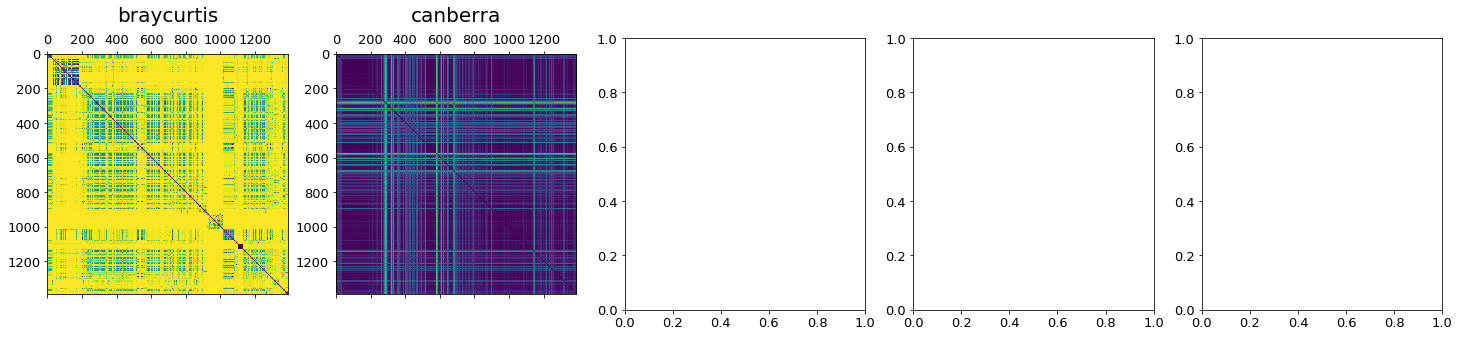

In [139]:
rows= 0
columns = 0
fig, axes = plt.subplots(numRows,5)
for keys in distanceGraphs:
    #print(keys)
    #print(distanceGraphs[keys])
    if columns == 5:
        columns = 0
        rows += 1
    if numRows == 1: #only takes columns argument if there is 1 row
        axes[columns].matshow(distanceGraphs[keys])
        axes[columns].set_title(keys, fontsize = 20, pad =20)
    else:
        axes[rows,columns].matshow(distanceGraphs[keys])
        axes[rows,columns].set_title(keys, fontsize = 20, pad = 20)
    columns += 1